# Test out globally fitted functions

In [1]:
# necessary: netcdf4-python, regionmask, (xarray, geopandas), cartopy, openpyxl, statsmodels

import numpy as np
import pandas as pd
import os, glob, re 
import math
import xarray as xr
import geopandas as gpd
import regionmask as regionmask
import dask
import matplotlib.pyplot as plt
import netCDF4

%matplotlib inline

#plotting
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from scipy.stats import norm


# import my variables settings functions from other scripts
from settings import *

# import fxns 
from functions import *
from utils import *
from plotscript import *

# import other packages/modules 

sys.path.append('../population/') # make this a module i can pip install and import ! 
from population_demographics_climate import * # move / rename this when good ! --> change to import demographics4climate as d4c

sys.path.append('../dist_cov/dist_cov/')
import distributions as distributions
#import sample as sample
import utils as utils 

In [2]:
start_message() # change indir to indir obs and datasets to datasets obs in start message

flags: {'models': 'ISIMIP3b', 'experiment': None, 'metric': 'TX99', 'method': 'empirical_percentile', 'time_method': 'single-year', 'shift_sigma': None, 'shift_period': None, 'chunk_version': 2, 'var': 'tasmax'}
var: tasmax
VARs: None
indir_p: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/InputData/climate/atmosphere/bias-adjusted/global/daily/
indir_s: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/SecondaryInputData/climate/atmosphere/bias-adjusted/global/daily/
indir_obs: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3a/InputData/climate/atmosphere/obsclim/global/daily/historical/
indir_counterclim: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3a/InputData/climate/atmosphere/counterclim/global/daily/historical/
GCMs: ['CanESM5', 'CNRM-CM6-1', 'GFDL-ESM4', 'IPSL-CM6A-LR', 'MIROC6', 'MRI-ESM2-0']
datasets: ['GSWP3-W5E5', '20CRv3-ERA5', '20CRv3-W5E5']
lat_chunk: 90
lon_chunk: 120
time_chunk: -1
outdirs: /data/brussel/vo/000/bvo00012/vsc1041

In [3]:
from dask.distributed import Client 
client = Client()
client

<Client: 'tcp://127.0.0.1:41343' processes=2 threads=2, memory=60.00 GiB>

# Test monthly model with loc and scale

To do: update to Forster2024 fitted data and compare with only loc models. Goodness of fit metric. Some uncertainty interval around the estimate. 

In [5]:
df_gmst_obs_annual = pd.read_csv(os.path.join('../../data/gmst/gmst-obs/forster2023/annual_averages.csv')).rename(
    columns={'timebound_lower':'year'}).set_index('year')[['gmst']]
gmst_smo = pd.DataFrame(apply_lowess(df_gmst_obs_annual, df_gmst_obs_annual.index, ntime=4))
gmst_smo

gmst
year          
1850 -0.043519
1851  0.032947
1852  0.066480
1853  0.059362
1854  0.050768
...        ...
2018  1.176428
2019  1.212890
2020  1.212564
2021  1.172323
2022  1.135193

[173 rows x 1 columns]

In [6]:
filepath = glob.glob(os.path.join('/data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output', 'output_shift-fit/forster2023/mon-loc-scale/WBGT/ISIMIP3a/GSWP3-W5E5/gswp3-w5e5_obsclim_WBGT_params_shift_*.nc'))[0]
print(filepath)
da_params = xr.open_dataarray(filepath)
da_params

/data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output/output_shift-fit/forster2023/mon-loc-scale/WBGT/ISIMIP3a/GSWP3-W5E5/gswp3-w5e5_obsclim_WBGT_params_shift_loc_sigma_mon_1901_2019.nc


<xarray.DataArray 'fit_params' (month: 12, lat: 360, lon: 720, params: 4)>
[12441600 values with dtype=float64]
Coordinates:
  * lon      (lon) float32 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float32 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * params   (params) object 'b0' 'b1' 'sigma_b0' 'sigma_b1'

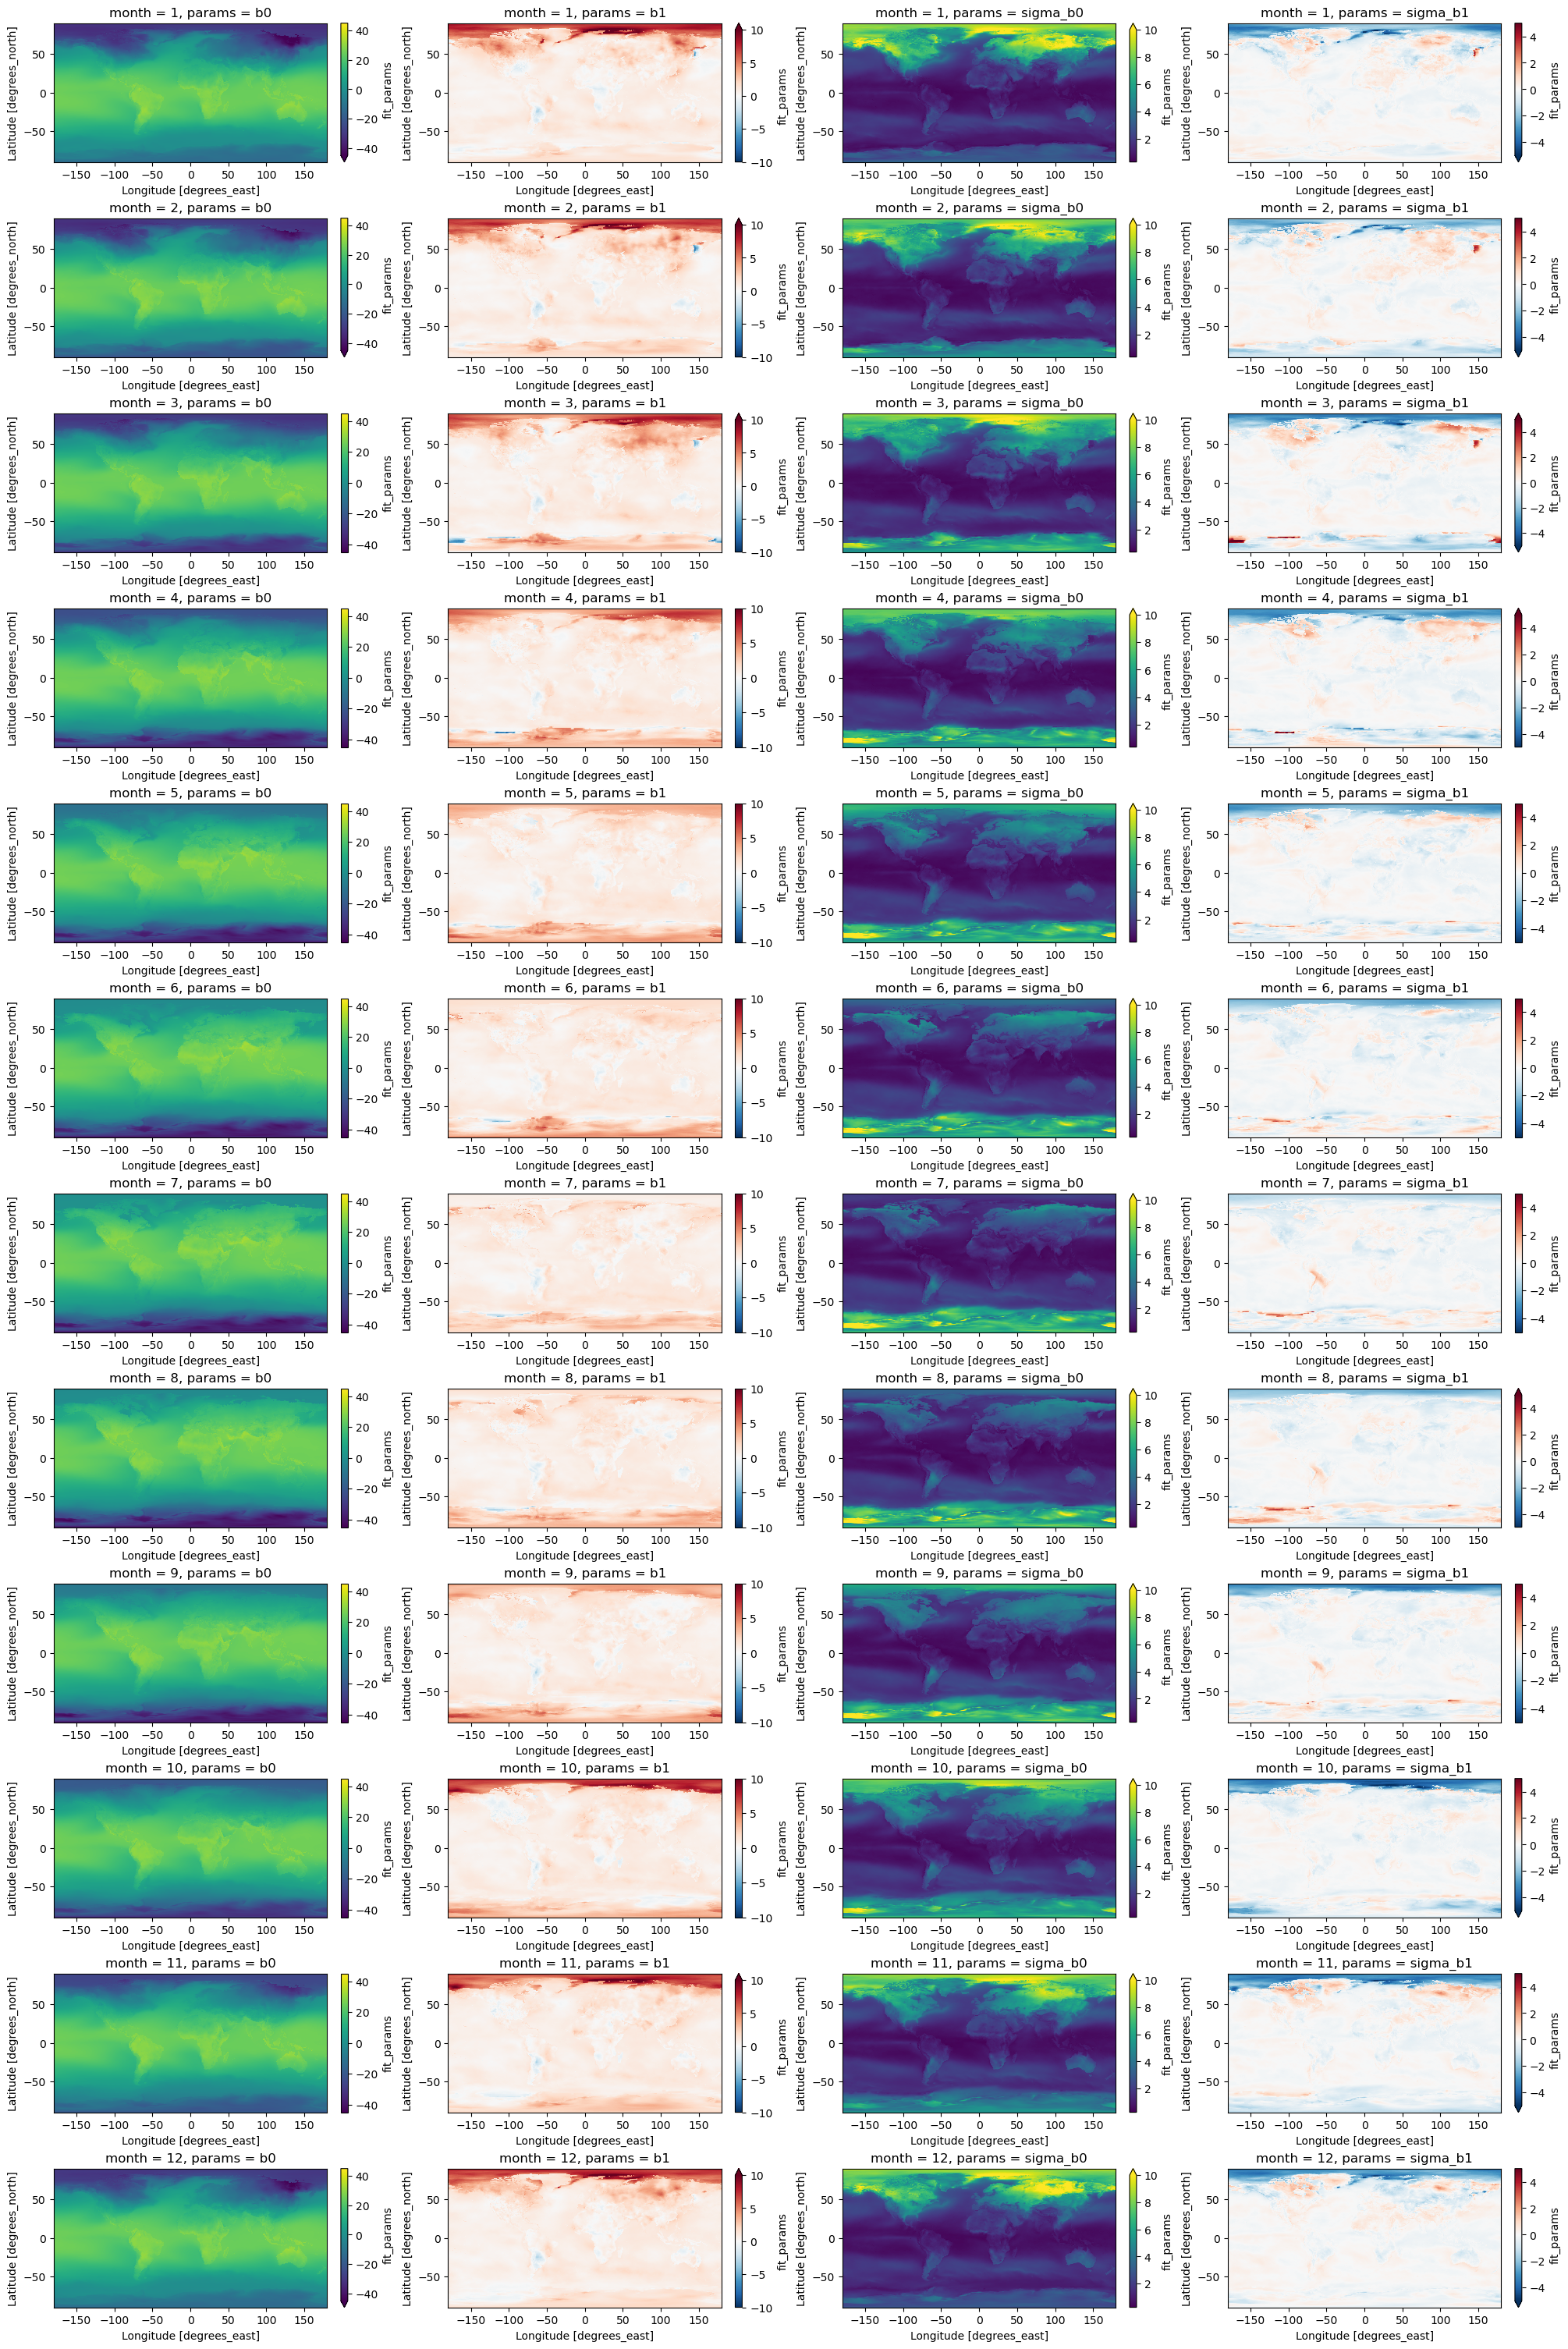

In [9]:
fig, axes = plt.subplots(12,4,figsize=(20,30), layout='constrained')

axes=axes.flatten()

j=0
#cmap='
for i in range(1,13):
    #print(j)
    da_params.sel(month=i,params='b0').plot(ax=axes[j],cmap='viridis',vmax=45)
    da_params.sel(month=i,params='b1').plot(ax=axes[j+1], vmax=10)
    da_params.sel(month=i,params='sigma_b0').plot(ax=axes[j+2], vmax=10)
    da_params.sel(month=i,params='sigma_b1').plot(ax=axes[j+3], vmax=5)
    j+=4

In [10]:
b0 = da_params.sel(params='b0')
b1 = da_params.sel(params='b1')
sigma_b0 = da_params.sel(params='sigma_b0')
sigma_b1 = da_params.sel(params='sigma_b1')

In [11]:

gmst_pres = float(gmst_smo.loc[2022]) # take smoothed or not smoothed covariate ?? i think not smoothed ??? 
gmst_pi = float(gmst_pres - 1.3)


norm_pi, norm_pres = norm(loc=b0+b1*gmst_pi, scale=sigma_b0+sigma_b1*gmst_pi), norm(loc=b0+b1*gmst_pres, scale=sigma_b0+sigma_b1*gmst_pres)

/tmp/ipykernel_1919527/1179301530.py:1: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  gmst_pres = float(gmst_smo.loc[2022]) # take smoothed or not smoothed covariate ?? i think not smoothed ???


In [12]:
d_countries = preprocess_all_country_population_data()
gs_population_global = get_gridscale_population_global( 
    d_countries,
    startyear=2022,
    endyear=None,
    save=False # change where this gets saved !!!! now its in package folder
)

interpolating cohort sizes per country
after interpolation and mean-preserving correction there are some neg numbers in 10, Azerbaijan, setting them to zero
after interpolation and mean-preserving correction there are some neg numbers in 98, Libya, setting them to zero
after interpolation and mean-preserving correction there are some neg numbers in 136, Papua New Guinea, setting them to zero
Aruba small, population not calculated
Antigua and Barbuda small, population not calculated
Bahrain small, population not calculated
Barbados small, population not calculated
Federated States of Micronesia small, population not calculated
Grenada small, population not calculated
Guam small, population not calculated
Saint Lucia small, population not calculated
Macao small, population not calculated
Maldives small, population not calculated
Malta small, population not calculated
Singapore small, population not calculated
Tonga small, population not calculated
calculating gridscale population per cou

## 1. WBGT28

In [13]:
threshold = 28 

data = norm_pres.sf(threshold) # probability of exceedance 
da_p1 = xr.DataArray(
    data=data,
    dims=["month", "lat", "lon"],
    coords=dict(
        lon=(["lon"], da_params.lon.data),
        lat=(["lat"], da_params.lat.data),
        month=da_params.month.data,) )

data = norm_pi.sf(threshold)
da_p0 = xr.DataArray(
    data=data,
    dims=["month", "lat", "lon"],
    coords=dict(
        lon=(["lon"], da_params.lon.data),
        lat=(["lat"], da_params.lat.data),
        month=da_params.month.data,) )

da_nAHD_mo = (da_p1 - da_p0) * 30.5 # change with actual length of each month??? what to about different lengths of februaries 

da_nAHD = da_nAHD_mo.sum(dim='month')

da_nAHD = da_nAHD.expand_dims("model").assign_coords(model=("model", [datasets[0]]))


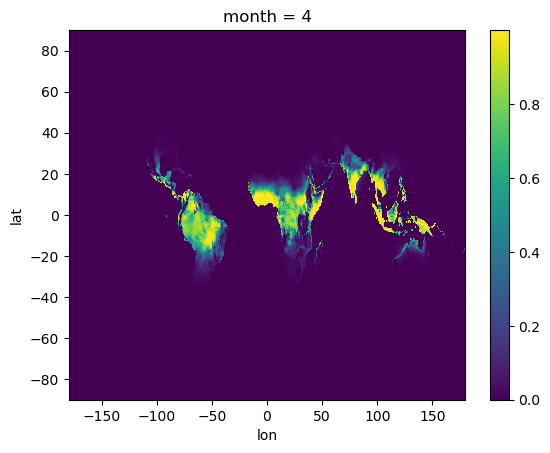

In [14]:
da_p1.sel(month=4).plot()

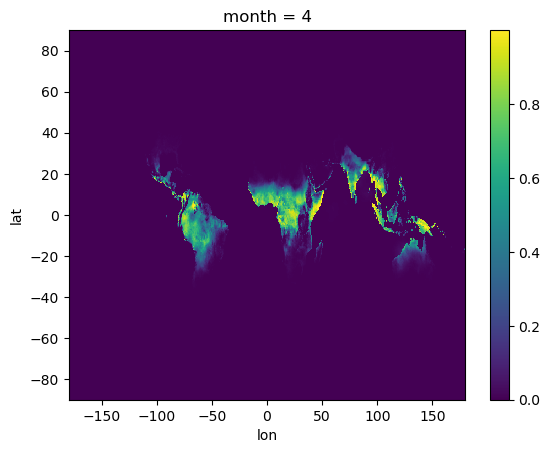

In [15]:
da_p0.sel(month=4).plot()

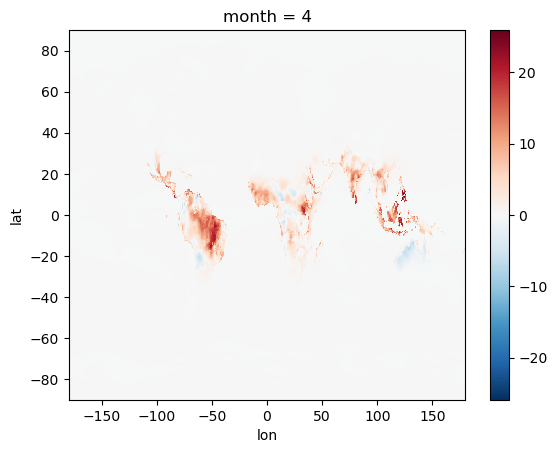

In [16]:
da_nAHD_mo.sel(month=4).plot()

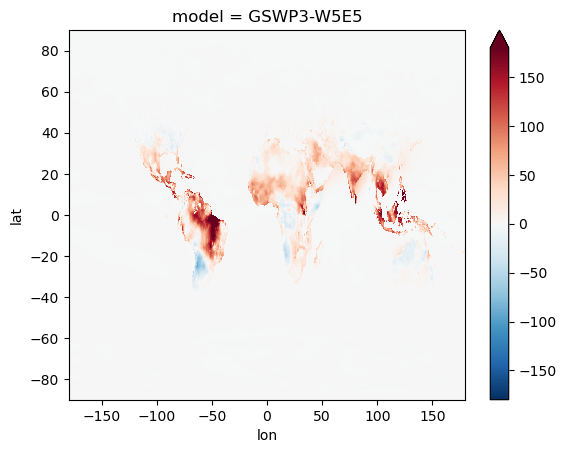

In [17]:
da_nAHD.plot(vmax=180)

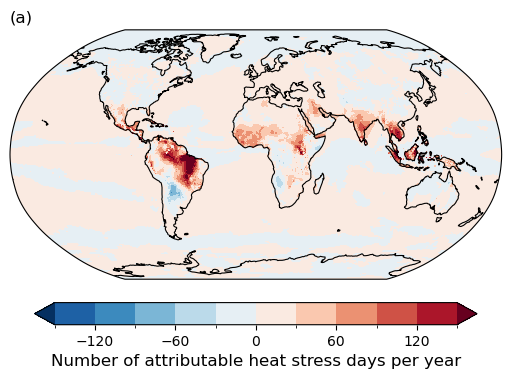

In [18]:
proj = ccrs.Robinson()
crs = ccrs.PlateCarree()

# make figure object
fig, ax = plt.subplots(figsize=(5,5), subplot_kw={'projection': proj},  layout='constrained')

data_plot = da_nAHD.isel(model=0)
plot = data_plot.plot(levels=11, vmax=150, vmin=-150, cmap='RdBu_r', transform=crs, extend='both', add_colorbar=False)
ax.coastlines(color='black', linewidth=0.8)

cbar_lab = 'Number of attributable heat stress days per year' # try to get TeX interpreter 'less likely $\leftarrow$ PR $\rightarrow$ more likely' #'PR' # add more/less likely arrow 
cbar = fig.colorbar(plot,  extend='both', ax=ax,  location='bottom',shrink=0.9) #, fraction= 0.045, pad= 0.04) #location='bottom' 
cbar.set_label(label=cbar_lab, size=12) 

plt.title('')
ax.set_title('(a)',loc='left');

#plt.savefig(os.path.join(figdirs,'fig_jun24_various/nAHD_isimip3a_v1.png'),dpi=300)

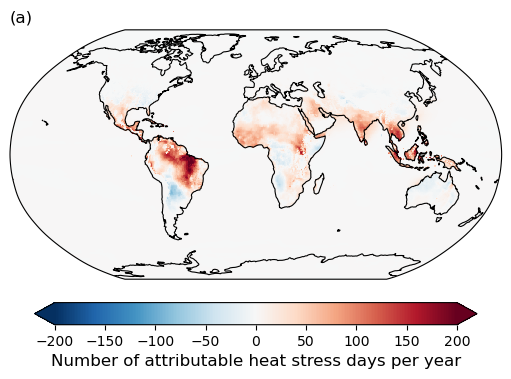

In [19]:
proj = ccrs.Robinson()
crs = ccrs.PlateCarree()

vmax = 200

# make figure object
fig, ax = plt.subplots(figsize=(5,5), subplot_kw={'projection': proj},  layout='constrained')

data_plot = da_nAHD.isel(model=0)
plot = data_plot.plot( vmax=vmax, vmin=-vmax, cmap='RdBu_r', transform=crs, extend='both', add_colorbar=False)
ax.coastlines(color='black', linewidth=0.8)

cbar_lab = 'Number of attributable heat stress days per year' # try to get TeX interpreter 'less likely $\leftarrow$ PR $\rightarrow$ more likely' #'PR' # add more/less likely arrow 
cbar = fig.colorbar(plot,  extend='both', ax=ax,  location='bottom',shrink=0.9) #, fraction= 0.045, pad= 0.04) #location='bottom' 
cbar.set_label(label=cbar_lab, size=12) 

plt.title('')
ax.set_title('(a)',loc='left');

#plt.savefig(os.path.join(figdirs,'fig_jun24_various/nAHD_isimip3a_v2.png'),dpi=300)

In [20]:
print(da_nAHD.sum().values, da_nAHD.min().values, da_nAHD.max().values, da_nAHD.mean().values)

836810.2032872436 -90.53083982875302 301.33366666403145 3.2284344262625138


## Latitudinal bands [TODO]

## Add demographics

In [21]:
da_n_people_ndays, da_prop_people_ndays = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, 
                                                                                          [datasets[0]], 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = [1,5,10,20,50])


da_nAHD_percapita_peopledays_10y = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                           [datasets[0]], 
                                           da_nAHD,
                                           x_hot_days = None, 
                                           ages_values=range(0,100),
                                           grouped = True,
                                           size_win = 10
                                           )


Text(0, 0.5, 'number of people (billions)')

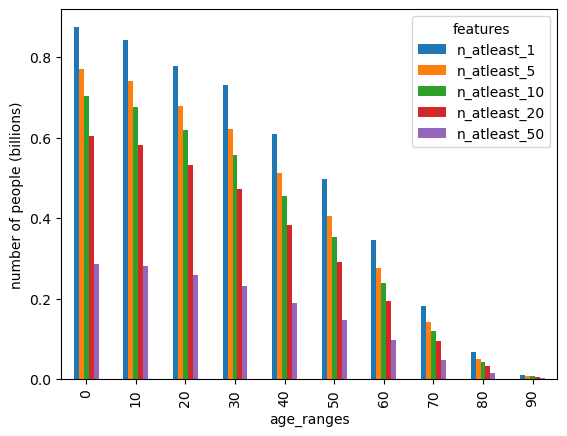

In [22]:
fig, ax = plt.subplots()

(da_n_people_ndays/1e9).to_pandas().plot.bar(ax=ax)
ax.set_ylabel(f'number of people (billions)')

Text(0, 0.5, 'proportion of people')

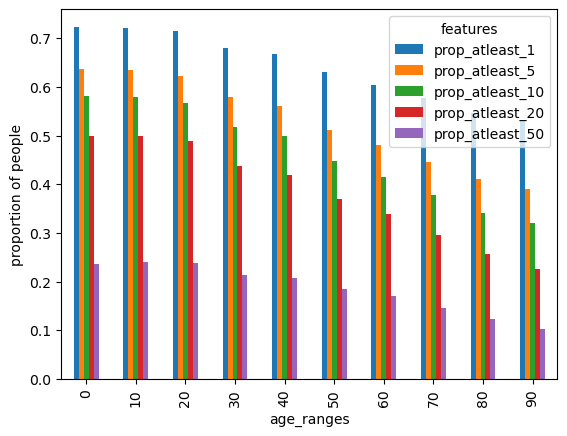

In [23]:
fig, ax = plt.subplots()

da_prop_people_ndays.to_pandas().plot.bar(ax=ax)
ax.set_ylabel(f'proportion of people')

In [24]:
df_percapitadays_10y = da_nAHD_percapita_peopledays_10y.sel(features='per_capita_days').to_pandas().T


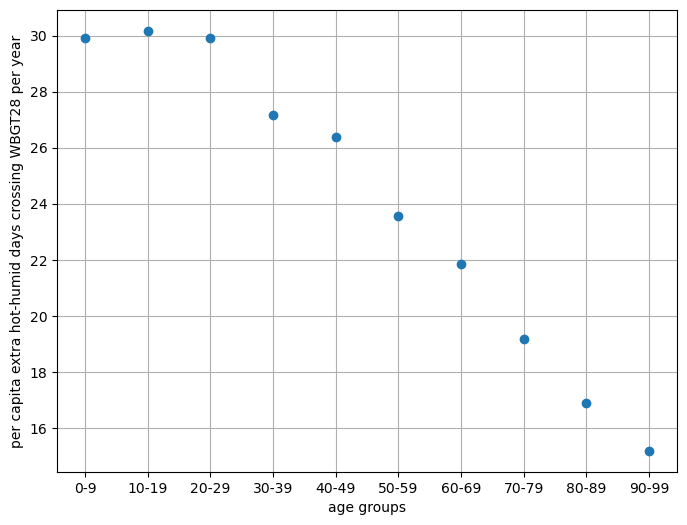

In [25]:
fig, ax = plt.subplots(figsize=(8,6))
df_plot = df_percapitadays_10y
df_plot.plot(marker='o',linestyle='None', ax=ax)
plt.ylabel('per capita extra hot-humid days crossing WBGT28 per year')
plt.xlabel('age groups')
plt.xticks(df_plot.index);
plt.grid()
ax.set_xticks(ticks=ax.get_xticks(), labels=[f'{x}-{x+9}' for x in df_plot.index], rotation='horizontal');


In [26]:
df_percapitadays_10y

age_ranges
0     29.905081
10    30.174299
20    29.912779
30    27.153948
40    26.370061
50    23.544585
60    21.856920
70    19.185846
80    16.878674
90    15.182160
dtype: float64

In [27]:
df_percapitadays_10y[0] / df_percapitadays_10y[60]

1.3682202915357156

## 1. WBGT30

In [76]:
threshold = 30

data = norm_pres.sf(threshold)
da_p1 = xr.DataArray(
    data=data,
    dims=["month", "lat", "lon"],
    coords=dict(
        lon=(["lon"], da_params.lon.data),
        lat=(["lat"], da_params.lat.data),
        month=da_params.month.data,) )

data = norm_pi.sf(threshold)
da_p0 = xr.DataArray(
    data=data,
    dims=["month", "lat", "lon"],
    coords=dict(
        lon=(["lon"], da_params.lon.data),
        lat=(["lat"], da_params.lat.data),
        month=da_params.month.data,) )

da_nAHD_mo = (da_p1 - da_p0) * 30.5 # change with actual length of each month

da_nAHD = da_nAHD_mo.sum(dim='month')

da_nAHD = da_nAHD.expand_dims("model").assign_coords(model=("model", [datasets[0]]))


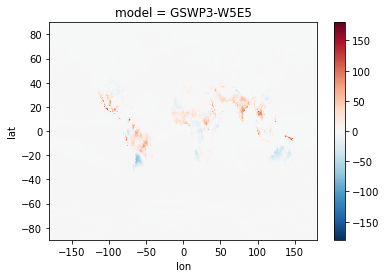

In [77]:
da_nAHD.plot(vmax=180)

In [78]:
print(da_nAHD.sum().values, da_nAHD.min().values, da_nAHD.max().values, da_nAHD.mean().values)

138068.1643923354 -79.0690612394357 147.96626274689217 0.5326703873161088


## Add demographics

In [79]:
da_n_people_ndays, da_prop_people_ndays = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, 
                                                                                          [datasets[0]], 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = [1,5,10,20,50])


da_nAHD_percapita_peopledays_10y = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                           [datasets[0]], 
                                           da_nAHD,
                                           x_hot_days = None, 
                                           ages_values=range(0,100),
                                           grouped = True,
                                           size_win = 10
                                           )


Text(0, 0.5, 'number of people (billions)')

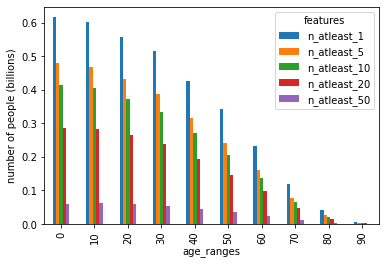

In [80]:
fig, ax = plt.subplots()

(da_n_people_ndays/1e9).to_pandas().plot.bar(ax=ax)
ax.set_ylabel(f'number of people (billions)')

Text(0, 0.5, 'proportion of people')

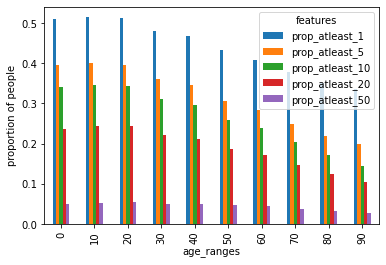

In [81]:
fig, ax = plt.subplots()

da_prop_people_ndays.to_pandas().plot.bar(ax=ax)
ax.set_ylabel(f'proportion of people')

In [82]:
df_percapitadays_10y = da_nAHD_percapita_peopledays_10y.sel(features='per_capita_days').to_pandas().T


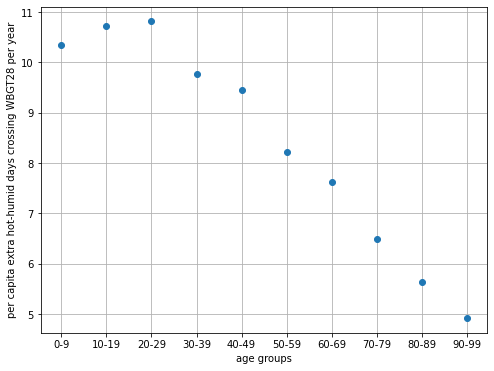

In [83]:
fig, ax = plt.subplots(figsize=(8,6))
df_plot = df_percapitadays_10y
df_plot.plot(marker='o',linestyle='None', ax=ax)
plt.ylabel('per capita extra hot-humid days crossing WBGT28 per year')
plt.xlabel('age groups')
plt.xticks(df_plot.index);
plt.grid()
ax.set_xticks(ticks=ax.get_xticks(), labels=[f'{x}-{x+9}' for x in df_plot.index], rotation='horizontal');


In [84]:
df_percapitadays_10y

age_ranges
0     10.349403
10    10.728283
20    10.811422
30     9.775559
40     9.444038
50     8.228272
60     7.622635
70     6.499572
80     5.633185
90     4.925872
dtype: float64

In [85]:
df_percapitadays_10y[0] / df_percapitadays_10y[60]

1.357719847699243

## 1. WBGT33

In [86]:
threshold = 33

data = norm_pres.sf(threshold)
da_p1 = xr.DataArray(
    data=data,
    dims=["month", "lat", "lon"],
    coords=dict(
        lon=(["lon"], da_params.lon.data),
        lat=(["lat"], da_params.lat.data),
        month=da_params.month.data,) )

data = norm_pi.sf(threshold)
da_p0 = xr.DataArray(
    data=data,
    dims=["month", "lat", "lon"],
    coords=dict(
        lon=(["lon"], da_params.lon.data),
        lat=(["lat"], da_params.lat.data),
        month=da_params.month.data,) )

da_nAHD_mo = (da_p1 - da_p0) * 30.5 # change with actual length of each month

da_nAHD = da_nAHD_mo.sum(dim='month')

da_nAHD = da_nAHD.expand_dims("model").assign_coords(model=("model", [datasets[0]]))


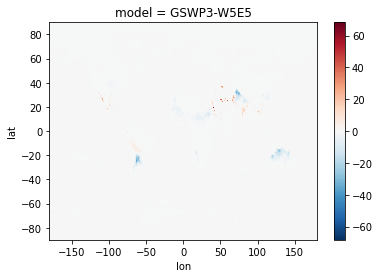

In [96]:
da_nAHD.plot()

In [88]:
print(da_nAHD.sum().values, da_nAHD.min().values, da_nAHD.max().values, da_nAHD.mean().values)

-15740.546112361651 -36.13577242418877 68.30391323348191 -0.06072741555695082


## Add demographics

In [89]:
da_n_people_ndays, da_prop_people_ndays = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, 
                                                                                          [datasets[0]], 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = [1,5,10,20,50])


da_nAHD_percapita_peopledays_10y = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                           [datasets[0]], 
                                           da_nAHD,
                                           x_hot_days = None, 
                                           ages_values=range(0,100),
                                           grouped = True,
                                           size_win = 10
                                           )


Text(0, 0.5, 'number of people (billions)')

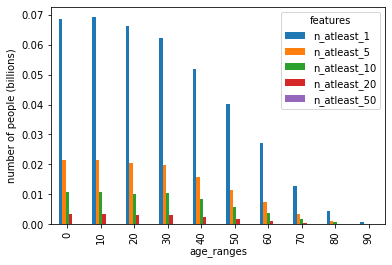

In [90]:
fig, ax = plt.subplots()

(da_n_people_ndays/1e9).to_pandas().plot.bar(ax=ax)
ax.set_ylabel(f'number of people (billions)')

Text(0, 0.5, 'proportion of people')

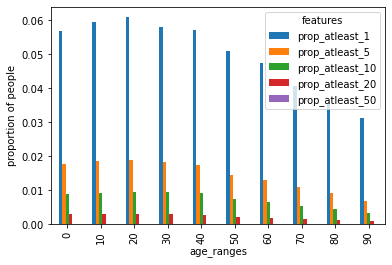

In [91]:
fig, ax = plt.subplots()

da_prop_people_ndays.to_pandas().plot.bar(ax=ax)
ax.set_ylabel(f'proportion of people')

In [92]:
df_percapitadays_10y = da_nAHD_percapita_peopledays_10y.sel(features='per_capita_days').to_pandas().T


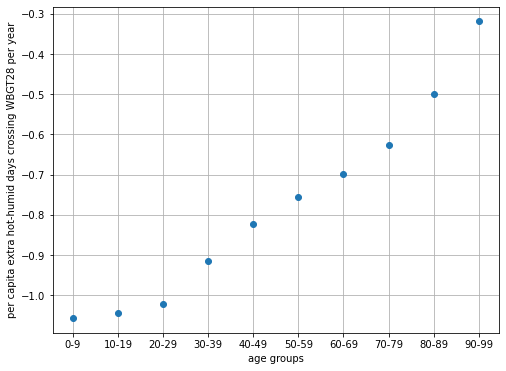

In [93]:
fig, ax = plt.subplots(figsize=(8,6))
df_plot = df_percapitadays_10y
df_plot.plot(marker='o',linestyle='None', ax=ax)
plt.ylabel('per capita extra hot-humid days crossing WBGT28 per year')
plt.xlabel('age groups')
plt.xticks(df_plot.index);
plt.grid()
ax.set_xticks(ticks=ax.get_xticks(), labels=[f'{x}-{x+9}' for x in df_plot.index], rotation='horizontal');


In [94]:
df_percapitadays_10y

age_ranges
0    -1.056574
10   -1.043241
20   -1.020756
30   -0.915321
40   -0.823558
50   -0.755444
60   -0.698508
70   -0.627352
80   -0.500474
90   -0.319145
dtype: float64

In [29]:
df_percapitadays_10y[0] / df_percapitadays_10y[60]

# living through 1.5 times LESS days crossing WBGT33 - this is a statistical artefact I think

1.3682202915357156